In [1]:
import librosa
import librosa.display
import numpy as np
import scipy
import tensorflow as tf
from sklearn import preprocessing
import pickle
import keras
from tqdm import tqdm
from tensorflow.keras.models import Model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.core import Lambda
from keras.layers import Input
from keras.layers.normalization import BatchNormalization
from keras.layers import LayerNormalization
from sklearn.model_selection import train_test_split

from keras.engine.topology import Layer
from keras.optimizers import SGD, Adam, Adagrad
import keras.backend as K
from keras import layers
from keras import activations
import math
import IPython.display as ipd
from keras.layers.advanced_activations import LeakyReLU
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import os
from os import listdir
from tensorflow.keras.layers import Input, Dense, LSTM, Bidirectional, Dropout, Flatten, TimeDistributed, Conv1D, MaxPooling1D, ConvLSTM2D, RepeatVector
%matplotlib inline

In [2]:
N = n_fft= 512
real = int(N/2)
im = int(N/2)
frame = N
stride = int(N/4)
SR = 16000
max_sec_dur = 7
maxlen = SR*max_sec_dur
pi=math.pi
maxlen

112000

In [3]:
n_fr = 872
total_len = N+stride*(n_fr-1)
total_len

112000

In [4]:
ab = np.load('ab_model_3_1_7_sec.npy')
ab_norm = np.load('ab_norm_model_3_1_7_sec.npy')
y_wave = np.load('y_wave_model_3_1_7_sec.npy')
y_wave_norm = np.load('y_wave_norm_model_3_1_7_sec.npy')
ab.shape, ab_norm.shape, y_wave.shape, y_wave_norm.shape

((13100, 872, 256), (13100, 872, 256), (13100, 112000), (13100, 112000))

In [5]:
test_ratio = 0.15

def split_test_train_raw(arr, test_ratio):
        train_slice = int(arr.shape[0]*(1-test_ratio))
        return arr[0:train_slice, ...], arr[train_slice:, ...]
    
#X_train, X_test = split_test_train_raw(arr = ab, test_ratio = test_ratio)
#y_train, y_test = split_test_train_raw(arr = y_wave, test_ratio = test_ratio)

X_train, X_test, y_train, y_test = train_test_split(ab, y_wave, test_size=0.2, random_state=42, shuffle=True)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((10480, 872, 256), (2620, 872, 256), (10480, 112000), (2620, 112000))

In [6]:
def get_real_imag_multipliers(N, real):
    def f_cos(a, N):
        return 2/N*np.cos(2*pi*a/N)

    def f_sin(a, N):
        return -2/N*np.sin(2*pi*a/N)

    n_k_mult = [[r*c for c in range(real)] for r in range(N)]
    vfunc =np.vectorize(f_cos)
    n_k_mult_cos = vfunc(n_k_mult, N)
    n_k_mult_cos = np.transpose(n_k_mult_cos)
    n_k_mult_cos = tf.convert_to_tensor(n_k_mult_cos, dtype='float32')
    vfunc =np.vectorize(f_sin)
    n_k_mult_sin = vfunc(n_k_mult, N)
    n_k_mult_sin = np.transpose(n_k_mult_sin)
    n_k_mult_sin = tf.convert_to_tensor(n_k_mult_sin, dtype='float32')
    return n_k_mult_cos, n_k_mult_sin

In [7]:
class Model_3_1:
    @staticmethod
    def _call_dense_layer(inputs, dim_hidden, activation = LeakyReLU(alpha=0.3) , name=None, dropout = None, bias = None, layer_norm=False):
        if bias:
            out = Dense(dim_hidden, activation=activation, name=name, use_bias=True, bias_initializer="ones")(inputs)
            
        else:
            out = Dense(dim_hidden, activation=activation, name=name)(inputs)
        
        if layer_norm:
            #out = BatchNormalization()(out)
            out = LayerNormalization()(out)
        
        if dropout:
            out = tf.keras.layers.Dropout(dropout)(out)
        
        return out

    
    @staticmethod
    def ifft_layer(x):
        global n_k_mult_cos
        global n_k_mult_sin 
        global real
        final = tf.matmul(x[:, :, :real], n_k_mult_cos) + tf.matmul(x[:,:,  real:], n_k_mult_sin)
        return final
    
    
    @staticmethod
    def _build(inputs_shape, dim_hidden, activations, dropout, bias):
        inputs = Input(shape=inputs_shape)
        
        def unit_model(inputs):
            #print(dim_hidden)
            for i, dim in enumerate(dim_hidden):
                name = "out_for_phase" if i == n_hidden - 1 else None
                dropout_l = None if i == n_hidden - 1 else dropout
                activation = None if i+1>len(activations) else activations[i]

                if i==n_hidden-1 and i==0:
                    out = Model_3_1._call_dense_layer(inputs = inputs, dim_hidden = dim, name = name, dropout=dropout_l, bias=bias, layer_norm=False, activation = activation)
                elif i==n_hidden-1:
                    out = Model_3_1._call_dense_layer(inputs = out, dim_hidden = dim, name = name, dropout=dropout_l, bias=bias, layer_norm=False, activation = activation)
                elif i == 0:
                    out = Model_3_1._call_dense_layer(inputs = inputs, dim_hidden = dim, name = name, dropout=dropout_l, bias=bias, activation = activation)   
                else:
                    out = Model_3_1._call_dense_layer(inputs = out, dim_hidden = dim, name = name, dropout=dropout_l, bias=bias, activation = activation)    

            out = Lambda(Model_3_1.ifft_layer, name = "out_for_wave")(out)
            return out

        
        out = unit_model(inputs)
        model = Model(
            inputs=inputs,
            outputs=out,
            name="model_final")
        
        # return the constructed network architecture
        return model
               

In [8]:
def build_and_compile(inputs_shape,
                     dim_hidden, 
                     activations, 
                     dropout,
                     bias,
                     opt, 
                     loss):
    model = Model_3_1._build(inputs_shape = inputs_shape, dim_hidden = dim_hidden, activations=activations, dropout = dropout, bias = bias)
    model.compile(optimizer=opt, loss=loss)
    return model

In [9]:
def loss_with_padding(y_true, y_pred):
    lst = []
    print(y_true.shape)
    print(y_pred.shape)
    for i in range(y_pred.shape[1]):
        #print(i)
        #paddings = tf.Variable([[0, 0,], [0, 0], [i*stride, total_len-N-i*stride]])
        paddings = np.array([[0, 0,], [0, 0], [i*stride, total_len-N-i*stride]])
        x = tf.pad(y_pred[:, i:i+1, :], paddings, "CONSTANT", np.nan)
        lst.append(x)
    #print(len(lst))
    ret = tf.concat(lst, axis=1)
    ret1 = tf.experimental.numpy.nanmean(ret, axis=1)
    loss1 = K.mean(K.square(tf.math.subtract(y_true, ret1)))
    return loss1

In [71]:
def loss_with_padding_2(y_true, y_pred):
    lst = []
    print(y_true.shape)
    print(y_pred.shape)
    for i in range(y_pred.shape[1]):
        #print(i)
        #paddings = tf.Variable([[0, 0,], [0, 0], [i*stride, total_len-N-i*stride]])
        paddings = np.array([[0, 0,], [0, 0], [i*stride, total_len-N-i*stride]])
        x = tf.pad(y_pred[:, i:i+1, :], paddings, "CONSTANT", np.nan)
        lst.append(x)
    #print(len(lst))
    ret = tf.concat(lst, axis=1)
    #print(tf.math.subtract(ret, y_true).shape)
    loss1 = tf.experimental.numpy.nanmean(K.square(tf.math.subtract(ret, y_true)))
    return loss1

In [10]:
n_k_mult_cos, n_k_mult_sin = get_real_imag_multipliers(N=n_fft, real = real)

In [132]:
EPOCHS= 1000
ALPHA = 1

LR = 1000
#opt = Adam(lr=LR)
opt = tf.keras.optimizers.SGD(learning_rate=LR, momentum=0.0, nesterov=False, name="SGD")
dropout = 0.2
bias = True
n_hidden = 2

batch_size = 1
use_one_frame = False
use_early_stopping = False
patience_early_stopping = 100
activation_function = 'tanh'

frame_number = 1000 if use_one_frame else None
activations = [activation_function]*(n_hidden-1)
#activations = [activation_function]*(n_hidden)
lossWeights = {"out_for_phase": ALPHA, "out_for_wave": 1-ALPHA}
#dim_hidden = [n_fft]*n_hidden
dim_hidden = [256, 512]


#loss='mse'
loss = loss_with_padding

comments = f"alpha_{ALPHA}_epochs_{EPOCHS}_n_fft_{n_fft}_activation_{activation_function}_n_hidden_{n_hidden}"
comments

'alpha_1_epochs_1000_n_fft_512_activation_tanh_n_hidden_2'

In [133]:
model = build_and_compile(inputs_shape = (X_train.shape[1], X_train.shape[2]),
                  dim_hidden = dim_hidden, 
                  activations=activations, 
                  dropout = dropout, 
                  bias = bias,
                 opt = opt, 
                 loss = loss)

In [134]:
n_k_mult_cos.shape

TensorShape([256, 512])

In [135]:
model.summary()

Model: "model_final"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 872, 256)]        0         
_________________________________________________________________
dense_13 (Dense)             (None, 872, 256)          65792     
_________________________________________________________________
dropout_13 (Dropout)         (None, 872, 256)          0         
_________________________________________________________________
out_for_phase (Dense)        (None, 872, 512)          131584    
_________________________________________________________________
out_for_wave (Lambda)        (None, 872, 512)          0         
Total params: 197,376
Trainable params: 197,376
Non-trainable params: 0
_________________________________________________________________


In [136]:
EPOCHS = 20
callbacks = []
sent_n = 1000


history = model.fit(x = X_train, y = y_train, 
          validation_data = (X_test, y_test),          
          epochs=EPOCHS, 
          batch_size=batch_size, 
          verbose=1,
            callbacks=callbacks)

# history = model.fit(x = X_train[sent_n-1:sent_n, :, :], y = y_train[sent_n-1:sent_n, :], 
#           validation_data = (X_test[sent_n-1:sent_n, :, :], y_test[sent_n-1:sent_n, :]),          
#           epochs=EPOCHS, 
#           batch_size=batch_size, 
#           verbose=1,
#             callbacks=callbacks)


Epoch 1/20
(1, 112000)
(1, 872, 512)
(1, 112000)
(1, 872, 512)
10480/10480 [==============================] - ETA: 0s - loss: 0.0036(1, 112000)
(1, 872, 512)
10480/10480 [==============================] - 730s 68ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 2/20
10480/10480 [==============================] - 706s 67ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 3/20
10480/10480 [==============================] - 710s 68ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 4/20
10480/10480 [==============================] - 711s 68ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 5/20
10480/10480 [==============================] - 710s 68ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 6/20
10480/10480 [==============================] - 710s 68ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 7/20
10480/10480 [==============================] - 709s 68ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 8/20
10480/10480 [==============================] - 710s 68ms/step - loss: 0.0034 - val_loss: 0.00

In [111]:
pred = model.predict(X_train[sent_n-1:sent_n, :, :])

In [112]:
pred.shape

(1, 872, 512)

In [113]:
def reshape_pred(y_pred):
    lst = []
    print(y_pred.shape)
    for i in range(y_pred.shape[1]):
        #print(i)
        #paddings = tf.Variable([[0, 0,], [0, 0], [i*stride, total_len-N-i*stride]])
        paddings = np.array([[0, 0,], [0, 0], [i*stride, total_len-N-i*stride]])
        x = tf.pad(y_pred[:, i:i+1, :], paddings, "CONSTANT", np.nan)
        lst.append(x)
    #print(len(lst))
    ret = tf.concat(lst, axis=1)
    ret1 = tf.experimental.numpy.nanmean(ret, axis=1)
    return ret1

In [114]:
pred_reshaped = reshape_pred(pred)
pred_reshaped.shape

(1, 872, 512)


(1, 112000)

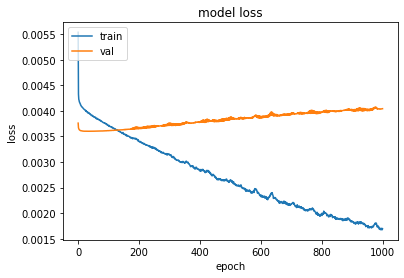

In [115]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

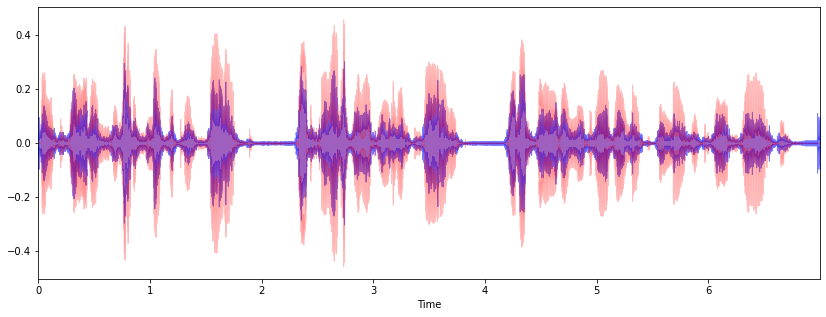

In [116]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(np.array(pred_reshaped).reshape(-1), sr=SR, color = 'b', alpha = 0.5)
librosa.display.waveplot(np.array(y_train[sent_n-1:sent_n, :]).reshape(-1), sr=SR, color = 'r', alpha = 0.25)
ipd.Audio(np.array(pred_reshaped).reshape(-1), rate=SR)

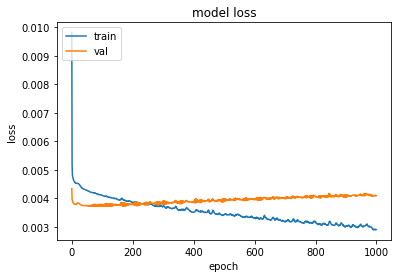

In [102]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

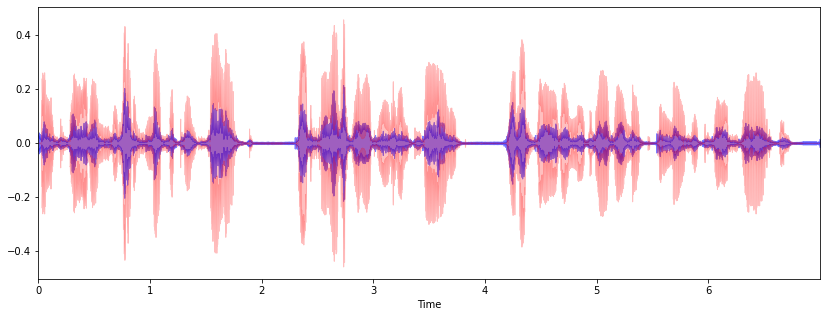

In [103]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(np.array(pred_reshaped).reshape(-1), sr=SR, color = 'b', alpha = 0.5)
librosa.display.waveplot(np.array(y_train[sent_n-1:sent_n, :]).reshape(-1), sr=SR, color = 'r', alpha = 0.25)
ipd.Audio(np.array(pred_reshaped).reshape(-1), rate=SR)

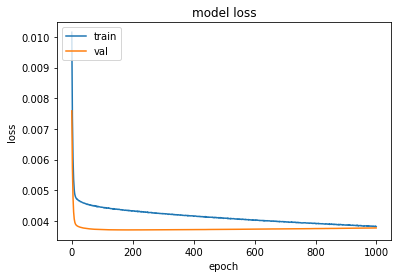

In [86]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

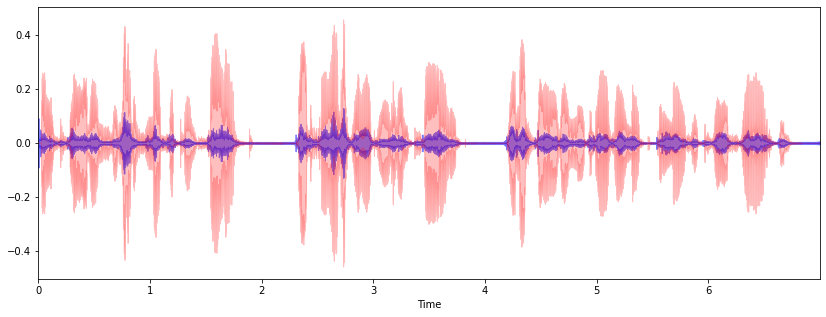

In [87]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(np.array(pred_reshaped).reshape(-1), sr=SR, color = 'b', alpha = 0.5)
librosa.display.waveplot(np.array(y_train[sent_n-1:sent_n, :]).reshape(-1), sr=SR, color = 'r', alpha = 0.25)
ipd.Audio(np.array(pred_reshaped).reshape(-1), rate=SR)

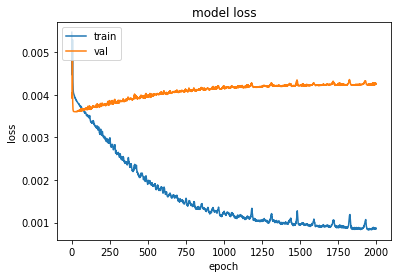

In [41]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

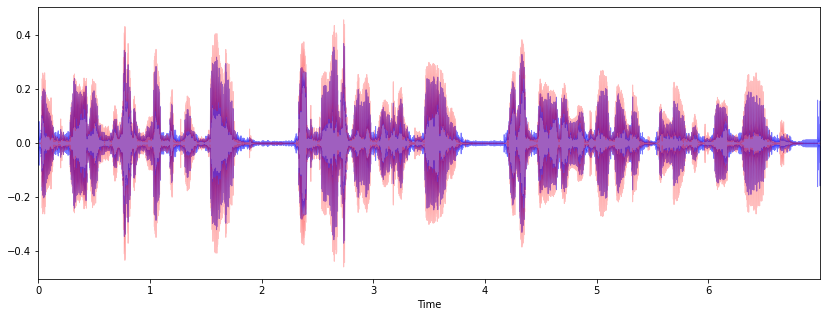

In [42]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(np.array(pred_reshaped).reshape(-1), sr=SR, color = 'b', alpha = 0.5)
librosa.display.waveplot(np.array(y_train[sent_n-1:sent_n, :]).reshape(-1), sr=SR, color = 'r', alpha = 0.25)
ipd.Audio(np.array(pred_reshaped).reshape(-1), rate=SR)

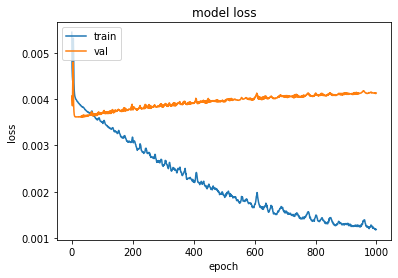

In [20]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

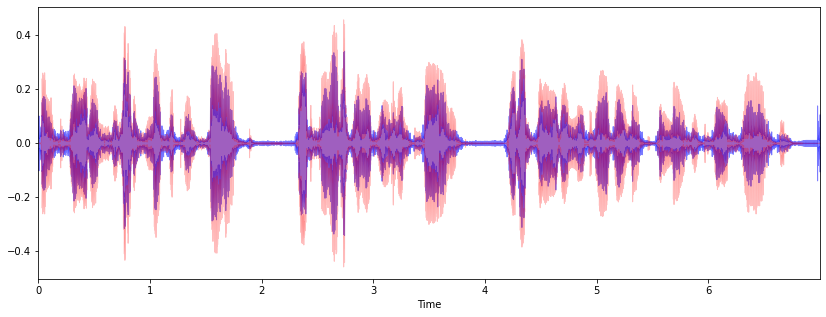

In [21]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(np.array(pred_reshaped).reshape(-1), sr=SR, color = 'b', alpha = 0.5)
librosa.display.waveplot(np.array(y_train[sent_n-1:sent_n, :]).reshape(-1), sr=SR, color = 'r', alpha = 0.25)
ipd.Audio(np.array(pred_reshaped).reshape(-1), rate=SR)

In [48]:
testing.shape

NameError: name 'testing' is not defined

In [49]:
y_pred_testing = tf.convert_to_tensor(np.random.random((1, X_train.shape[1], N)))
y_true_testing = tf.convert_to_tensor(np.random.random((1, 112000)))
y_pred_testing.shape, y_true_testing.shape

(TensorShape([1, 872, 512]), TensorShape([1, 112000]))

In [69]:
def loss_with_padding_2(y_true, y_pred):
    lst = []
    print(y_true.shape)
    print(y_pred.shape)
    for i in range(y_pred.shape[1]):
        #print(i)
        #paddings = tf.Variable([[0, 0,], [0, 0], [i*stride, total_len-N-i*stride]])
        paddings = np.array([[0, 0,], [0, 0], [i*stride, total_len-N-i*stride]])
        x = tf.pad(y_pred[:, i:i+1, :], paddings, "CONSTANT", np.nan)
        lst.append(x)
    #print(len(lst))
    ret = tf.concat(lst, axis=1)
    #print(tf.math.subtract(ret, y_true).shape)
    loss1 = tf.experimental.numpy.nanmean(K.square(tf.math.subtract(ret, y_true)))
    return loss1

In [23]:
def loss_with_padding(y_pred, y_true):
    lst = []
    for i in range(y_pred.shape[1]):
        #print(i)
        paddings = tf.Variable([[0, 0,], [0, 0], [i*stride, total_len-N-i*stride]])
        x = tf.pad(y_pred[:, i:i+1, :], paddings, "CONSTANT", np.nan)
        lst.append(x)
    #print(len(lst))
    ret = tf.concat(lst, axis=1)
    ret1 = tf.experimental.numpy.nanmean(ret, axis=1)
    loss1 = K.mean(K.square(tf.math.subtract(y_true, ret1)))
    return loss1

In [70]:
l = loss_with_padding_2(y_true_testing, y_pred_testing)
l

(1, 112000)
(1, 872, 512)
(1, 872, 112000)


ndarray<<tf.Tensor: shape=(), dtype=float64, numpy=0.16698082922504404>>

In [68]:
l = loss_with_padding(y_true_testing ,y_pred_testing)
l

(1, 112000)
(1, 872, 512)


<tf.Tensor: shape=(), dtype=float64, numpy=0.10455501169985158>

In [24]:
l = loss_with_padding(y_pred_testing, y_true_testing)
l

872


<tf.Tensor: shape=(), dtype=float64, numpy=0.10448286353538644>

In [35]:
#(tf.convert_to_tensor(np.ones((2,4, 6))))

ret1 = loss_f(testing)
ret1.shape

872


(1, 112000)

In [32]:
#(tf.convert_to_tensor(np.ones((2,4, 6))))

ret = loss_f(testing)
ret.shape

872


TensorShape([1, 872, 112000])

In [33]:
ret[0][1][128:128+513]

<tf.Tensor: shape=(513,), dtype=float64, numpy=
array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,

In [224]:
y_test.shape

(1965, 112000)

In [116]:
512+512/4*(872-1)

112000.0

In [122]:
pred = tf.convert_to_tensor(np.array((y_test.shape[0], X_train.shape[1], N)))
pred, y_test.shape

(<tf.Tensor: shape=(3,), dtype=int64, numpy=array([1965,  872,  512])>,
 (1965, 112000))

In [166]:
def pad_t(inp):
    paddings = tf.Variable([[0, 0,], [2, 2]])
    return tf.pad(inp, paddings, 'CONSTANT')

In [15]:
frame_np = np.ones((N))
n_fr = 872
total_len = N+stride*(n_fr-1)
mask = [np.pad(frame_np, (i*stride, total_len-N-i*stride), 'constant', constant_values=(0., 0.)) for i in range(n_fr)]
mask=np.array(mask).astype(bool)
mask

array([[ True,  True,  True, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ...,  True,  True,  True]])

In [139]:
a=np.array([1, 2, 3, 4, 6, 5])
b=np.array([False, False, True, True, True, True])
a*b

array([0, 0, 3, 4, 6, 5])

In [146]:
inp =tf.convert_to_tensor(np.ones((2,4)))
inp

<tf.Tensor: shape=(2, 4), dtype=float64, numpy=
array([[1., 1., 1., 1.],
       [1., 1., 1., 1.]])>

In [167]:
pad_t(inp)

InvalidArgumentError: paddings must be a matrix with 2 columns: [2,2,2] [Op:Pad]